<a href="https://colab.research.google.com/github/Rabbia-Ijaz/TryItOut/blob/main/TailorMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import cv2

import copy
import math
from tensorflow.keras.models import load_model
import tensorflow as tf
import sys
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
import pickle
import numpy as np
import cv2
from random import randint
import os
!pip install blend_modes
from blend_modes import soft_light
from IPython.display import display, Image


In [3]:
def Display(a,title1="test"):
  cv2.imwrite(title1+'.jpg',a)
  print(title1)
  display(Image(filename=title1+'.jpg'))


test


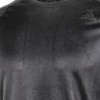

test


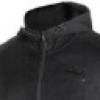

test


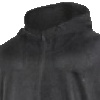

side 1 : 100.71742649611338   side 2 : 101.11874208078342
degreee : 2.0842904774567215
test


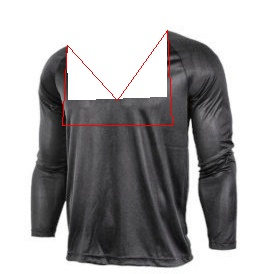

test


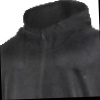

test


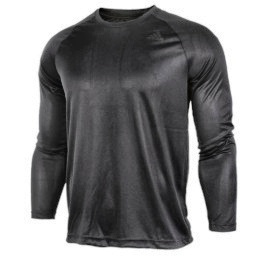

test


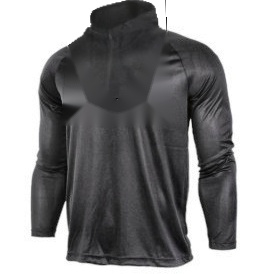

In [ ]:

def checkOutliers (val):
  if (all(val) >all([250, 250, 250]) or all(val) < all([5, 5, 5])):
    return False
  else:
    return True

def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

def getDifference (sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim):
  cons = [0,0,0,0]
  check=[0,0,0,0]
  for i in range (targBoxDim[0]):
      if (sourceLines[i][0] == 255 and check[0]==0):
          cons[0]=i
          check[0]=1
      if (targetLines[i][targBoxStart[0]] == 255 and check[1]==0):
          cons[2]=i
          check[1]=1
      if (sourceLines[i][targBoxDim[0]-1] == 255 and check[2]==0):
          cons[1]=i
          check[2]=1
      if (targetLines[i][targBoxStart[0] + targBoxDim[0]] == 255 and check[3]==0):
          cons[3]=i
          check[3]=1
  return cons

def Blending(source,target,tarStart,tarEnd):
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))
    size=(targBoxDim[1],targBoxDim[0],3)
    tar=np.zeros(size, dtype = np.uint8)
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))

    for i in range(0,targBoxDim[1]):
      for j in range(0,targBoxDim[0]):
        tar[i][j]=target[tarStart[1]+i+20][tarStart[0]+j]
    Display(tar)

    sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)

    source2 = cv2.cvtColor(sourceResized, cv2.COLOR_BGR2GRAY ) 
    source2 = cv2.GaussianBlur(source2,(5,5),0)
    thresh = cv2.threshold(source2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    Display(sourceResized)

    #tar = np.asarray(tar, np.float64)
    #sourceResized = np.asarray(sourceResized, np.float64)

    blended = cv2.addWeighted(tar, 0.5, sourceResized,0.5, 1)
    #blended=blended.astype( np.uint8)
    #blended=cv2.resize(blended, (source.shape[0],source.shape[1]), interpolation=cv2.INTER_AREA)

    for i in range(blended.shape[0]):
      for j in range(blended.shape[1]):
        if thresh[i][j]==255:
          blended[i][j]=(255,255,255)

    Display(blended)
    return blended

source = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/collar.jpg")
target = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/shirt.jpg")

#source = cv2.imread(r"A:\University\Semester 7\FYP-1\DATA\DATA\Collar\collar\6655_563485317402-00004.jpg", 0)
#target = cv2.imread(r"A:\University\Semester 7\FYP-1\DATA\DATA\Collar\target\6655_43789538835-00004.jpg", 0)




targBoxStart =(67, 0)
targBoxEnd = (167, 100)
targBoxDim = ((targBoxEnd[0]-targBoxStart[0]), (targBoxEnd[1]-targBoxStart[1]))
source = Blending(source, target, targBoxStart, targBoxEnd)

targetLines = cv2.Canny(target, 100, 200)

sourceDim = source.shape[0:1]
targetDim = target.shape[0:1]

sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)


sourceLines = cv2.Canny(sourceResized, 100, 200)
sourceConnect1, sourceConnect2,  targetConnect1, targetConnect2 = getDifference(sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim)
leftDif = targetConnect1 - sourceConnect1

count = 0

side1 = np.sqrt((targBoxDim[1])**2 + (sourceConnect2-sourceConnect1)**2)
side2 = np.sqrt((targBoxDim[1])**2 + (targetConnect2-targetConnect1)**2)
oppSide = targetConnect2 - sourceConnect2

print ("side 1 : " + str(side1) +"   side 2 : " + str(side2))
degree = ((side1**2) + (side2**2)-(oppSide**2))/(2*side1*side2)
degree = math.acos(degree)*10
print ("degreee : " + str(degree))



sourceRotated = rotate(sourceResized, degree, center = (0, sourceConnect1))
sourceLines = cv2.Canny(sourceRotated, 100, 200)

difference = 0
result = copy.deepcopy(target)

if (sourceConnect1>targetConnect1):
  difference = sourceConnect1-targetConnect1
  result = cv2.copyMakeBorder(result, top = difference, bottom = 0, left = 0, right = 0, borderType=cv2.BORDER_CONSTANT, value = (255, 255, 255))

#Hue Correction 224


for x in range(targBoxStart[0], targBoxEnd[0]):
    for y in range(targBoxStart[1], targBoxEnd[1]):
      if (checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]])):
        result[y + (targetConnect1 - sourceConnect1 + difference) ,x]=(255,255,255)


line = copy.deepcopy(result)
point1 = (targBoxStart[0], targetConnect1+difference)
point2 = ((targBoxStart[0] + targBoxEnd[0])/2,targBoxEnd[1])
temp1=int(point2[0])
temp2=int(point2[1])
point2=(temp1, temp2)
point3 = (targBoxEnd[0], targetConnect2+difference)
point4 = (targBoxEnd[0]+ 5, targBoxEnd[1] + 25)
point5 = (targBoxStart[0]- 5, targBoxEnd[1] + 25)


mask = np.zeros((target.shape[0]+difference, target.shape[1], 1), np.uint8)

pts = np.array([point1,point2,point3,point4, point5], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(mask,[pts],True,(255))
cv2.polylines(result,[pts],True,(0,0,255))

Display(result)

maskThresh = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(maskThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(mask, [c], -1, (255,255,255), -1)



for x in range(targBoxStart[0], targBoxEnd[0]):
    for y in range(targBoxStart[1], targBoxEnd[1]):
      if (checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]])):
        result[y + (targetConnect1 - sourceConnect1 + difference), x] = sourceRotated[y - targBoxStart[1], x - targBoxStart[0]]

result = cv2.inpaint(result,mask,3,cv2.INPAINT_TELEA)

# for i in range(result.shape[0]):
#   for j in range(result.shape[1]):
#     if (mask[i,j]==255):
#       result[i,j] = cv2.blur(result[i,j], (20,20))

Display(sourceRotated)
Display(target)

Display( result)


# User

In [4]:
class User:         #dummy User Class
  def __init__(self, N="", I=0):
    self.Name = N
    self.ID = I
  def UserDetails(self):
    print("Username: "+ self.Name)
    print("User ID: "+ str(self.ID))
  def returnDetails(self):
    return self.Name,self.ID

# Data

In [5]:
class Data:        #Data input class
  def __init__(self, src, tar):
    self.Source = src
    self.Target = tar
  
  def InputResize(self,img):
    return cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)

  def InputData(self):
    x = open("/content/drive/MyDrive/Colab Notebooks/model2.pkl",'rb')
    model = pickle.load(x)
    srcImg = cv2.imread(self.Source)
    srcImg = self.InputResize(srcImg)

    img = srcImg.flatten()
    srCpred = model.predict([img])
    
    #pred is array: [x1,y1,x2,y2] (x1,y1) top left (x2,y2) bottom right

    SrcBoxStart =( int(srCpred[0][0]), int(srCpred[0][1]))
    SrcBoxEnd = (int(srCpred[0][2]), int(srCpred[0][3]))
    SrcBoxDim = ((SrcBoxEnd[0]-SrcBoxStart[0]), (SrcBoxEnd[1]-SrcBoxStart[1]))    
    size=(SrcBoxDim[1],SrcBoxDim[0],3)
    tempSrc=np.zeros(size, dtype = np.uint8)

    for i in range(0,SrcBoxDim[1]):
      for j in range(0,SrcBoxDim[0]):
        tempSrc[i][j]=srcImg[SrcBoxStart[1]+i][SrcBoxStart[0]+j]
    
    targImg = cv2.imread(self.Target)
    targImg = self.InputResize(targImg)
    img2 = targImg.flatten()
    targpred = model.predict([img2])
    x.close()
    TarBoxStart =(int(targpred[0][0]), int(targpred[0][1]))
    TarBoxEnd = (int(targpred[0][2]), int(targpred[0][3]))
    
    

    return tempSrc, targImg, TarBoxStart, TarBoxEnd
    

# Preprocessing

In [6]:
class PreProcessing:    #Preprocessing class
  def __init__(self):
    print("Preprocessing")

  def Blending(self,source,target,tarStart,tarEnd):
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))
    size=(targBoxDim[1],targBoxDim[0],3)
    tar=np.zeros(size, dtype = np.uint8)
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))

    for i in range(0,targBoxDim[1]):
      for j in range(0,targBoxDim[0]):
        tar[i][j]=target[tarStart[1]+i][tarStart[0]+j]
    Display(tar)

    sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)

    source2 = cv2.cvtColor(sourceResized, cv2.COLOR_BGR2GRAY ) 
    source2 = cv2.GaussianBlur(source2,(5,5),0)
    thresh = cv2.threshold(source2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    Display(sourceResized)

    
    blended = cv2.addWeighted(tar, 0.2, sourceResized,1, 0)
    
    for i in range(blended.shape[0]):
      for j in range(blended.shape[1]):
        if thresh[i][j]==255:
          blended[i][j]=(255,255,255)

    Display(blended)
    return blended

# TailorMod

In [13]:
class TextureMod:    #TextureMod model class
  def __init__(self):
    print ("The TextureMod model has been created")

  def checkOutliers (self,val):
    if (all(val) >all([250, 250, 250]) or all(val) < all([5, 5, 5])):
      return False
    else:
      return True

  def rotate(self,image, angle, center = None, scale = 1.0):
      (h, w) = image.shape[:2]

      if center is None:
          center = (w / 2, h / 2)

      # Perform the rotation
      M = cv2.getRotationMatrix2D(center, angle, scale)
      rotated = cv2.warpAffine(image, M, (w, h))

      return rotated

  def getDifference (self,sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim):
    cons = [0,0,0,0]
    check=[0,0,0,0]
    for i in range (targBoxDim[0]):
        if (sourceLines[i][0] == 255 and check[0]==0):
            cons[0]=i
            check[0]=1
        if (targetLines[i][targBoxStart[0]] == 255 and check[1]==0):
            cons[2]=i
            check[1]=1
        if (sourceLines[i][targBoxDim[0]-1] == 255 and check[2]==0):
            cons[1]=i
            check[2]=1
        if (targetLines[i][targBoxStart[0] + targBoxDim[0]] == 255 and check[3]==0):
            cons[3]=i
            check[3]=1
    return cons
  
  def Mapping(self,source,target,targBoxDim,targBoxStart,targBoxEnd):
    
    targetLines = cv2.Canny(target, 100, 200)
    sourceDim = source.shape[0:1]
    targetDim = target.shape[0:1]

    sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)


    sourceLines = cv2.Canny(sourceResized, 100, 200)
    sourceConnect1, sourceConnect2,  targetConnect1, targetConnect2 = self.getDifference(sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim)
    leftDif = targetConnect1 - sourceConnect1

    count = 0

    side1 = np.sqrt((targBoxDim[1])**2 + (sourceConnect2-sourceConnect1)**2)
    side2 = np.sqrt((targBoxDim[1])**2 + (targetConnect2-targetConnect1)**2)
    oppSide = targetConnect2 - sourceConnect2

    print ("side 1 : " + str(side1) +"   side 2 : " + str(side2))
    degree = ((side1**2) + (side2**2)-(oppSide**2))/(2*side1*side2)
    degree = math.acos(degree)*10
    print ("degreee : " + str(degree))



    sourceRotated = self.rotate(sourceResized, degree, center = (0, sourceConnect1))
    sourceLines = cv2.Canny(sourceRotated, 100, 200)

    difference = 0
    result = copy.deepcopy(target)

    if (sourceConnect1>targetConnect1):
      difference = sourceConnect1-targetConnect1
      result = cv2.copyMakeBorder(result, top = difference, bottom = 0, left = 0, right = 0, borderType=cv2.BORDER_CONSTANT, value = (255, 255, 255))

    #Hue Correction 224


    for x in range(targBoxStart[0], targBoxEnd[0]):
        for y in range(targBoxStart[1], targBoxEnd[1]):
          if (self.checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]])):
            result[y + (targetConnect1 - sourceConnect1 + difference) ,x]=(255,255,255)


    line = copy.deepcopy(result)
    point1 = (targBoxStart[0], targetConnect1+difference)
    point2 = ((targBoxStart[0] + targBoxEnd[0])/2,targBoxEnd[1])
    temp1=int(point2[0])
    temp2=int(point2[1])
    point2=(temp1, temp2)
    point3 = (targBoxEnd[0], targetConnect2+difference)
    point4 = (targBoxEnd[0]+ 5, targBoxEnd[1] + 10)
    point5 = (targBoxStart[0]- 5, targBoxEnd[1] + 10)


    mask = np.zeros((target.shape[0]+difference, target.shape[1], 1), np.uint8)

    pts = np.array([point1,point2,point3,point4, point5], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(mask,[pts],True,(255))
    cv2.polylines(result,[pts],True,(0,0,255))

    Display(result)

    maskThresh = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(maskThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)



    for x in range(targBoxStart[0], targBoxEnd[0]):
        for y in range(targBoxStart[1], targBoxEnd[1]):
          if (self.checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]])):
            result[y + (targetConnect1 - sourceConnect1 + difference), x] = sourceRotated[y - targBoxStart[1], x - targBoxStart[0]]

    result = cv2.inpaint(result,mask,3,cv2.INPAINT_TELEA)


    Display(sourceRotated)
    Display(target)

    #Display(result)
    return result
  
  
        

# Result

In [8]:
class Result:    #Result class
  def __init__(self, img):
   self.result=img

  def showResult(self):
    Display(self.result,"FinalResult")
    

# Database

In [9]:
class Database:    #Database class
  def __init__(self, name,id):
   self.Name=name
   self.ID=id
   self.Photos=[]

  def showDatabase(self):
    print("Name: "+ self.Name)
    print("ID: "+ str(self.ID))
    for i in range(0,len(self.Photos)):
      temp="title"+str(i)
      Display(self.Photos[i],temp)

  def AddToDatabase(self,img):
    self.Photos.append(img)
    

# Main

Source


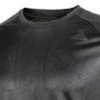

Target


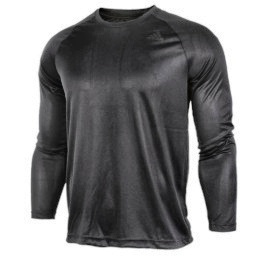

Preprocessing
test


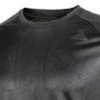

test


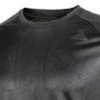

test


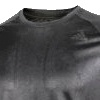

The TextureMod model has been created
side 1 : 100.31948963187563   side 2 : 100.31948963187563
degreee : 0.0
test


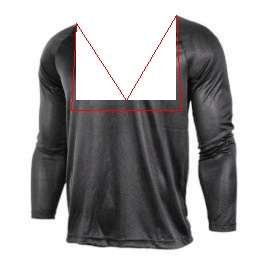

test


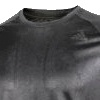

test


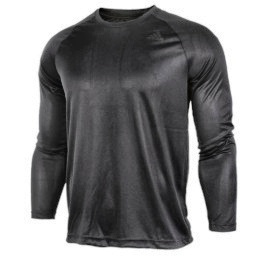

test


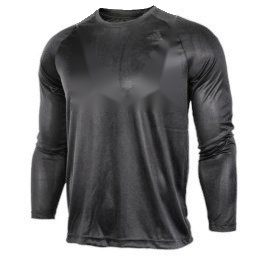

FinalResult


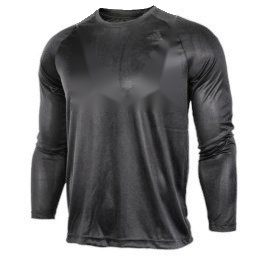

Name: Rabbia
ID: 123
title0


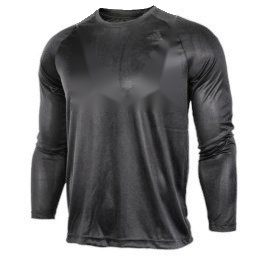

In [14]:
NewUser= User("Rabbia",123)

NewData=Data("/content/drive/MyDrive/Colab Notebooks/shirt.jpg","/content/drive/MyDrive/Colab Notebooks/shirt.jpg")
source, target, targBoxStart, targBoxEnd=NewData.InputData()
Display(source,"Source")
Display(target,"Target")
targBoxDim = ((targBoxEnd[0]-targBoxStart[0]), (targBoxEnd[1]-targBoxStart[1]))


Preprocess=PreProcessing()
source = Preprocess.Blending(source,target, targBoxStart,targBoxEnd)
TextureModel=TextureMod()
result=TextureModel.Mapping(source,target,targBoxDim,targBoxStart,targBoxEnd)

Display(result)

FinalResult=Result(result)
FinalResult.showResult()

Name,ID=NewUser.returnDetails()
DB=Database(Name,ID)
DB.AddToDatabase(result)
DB.showDatabase()